<a href="https://colab.research.google.com/github/ahmedelalaoui142/control-engineering-with-python-project-2023-2024/blob/master/Project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>

### Python Dependencies

In [ ]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Scooter Planar Model
================================

### Introduction

We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

  - The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

  - Two fixed wheels (their orientation with respect to the frame does not change).
    They are parallel and located at opposite ends of the frame.
    
Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.

### Parameter Definition

From now on, we assume that the seat frame length is $\ell = 50 \mbox{ cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

In [ ]:
l = 0.5  # seat frame length in meters
r = 0.125  # wheel radius in meters


### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [17]:
def draw_scooter(x, y, theta):

    #Wheels
    #right wheel
    x1 = x + sin(theta)*l/2
    y1 = y - cos(theta)*l/2
    x1_ = linspace(x1-cos(theta)*r,x1+cos(theta)*r, 100)
    y1_ = linspace(y1-sin(theta)*r,y1+sin(theta)*r, 100)
    plot(x1_, y1_, '-', linewidth=4,color='black')

    #left wheel
    x2 = x - sin(theta)*l/2
    y2 = y + cos(theta)*l/2
    x2_ = linspace(x2-cos(theta)*r,x2+cos(theta)*r, 100)
    y2_ = linspace(y2-sin(theta)*r,y2+sin(theta)*r, 100)
    plot(x2_, y2_, '-',linewidth=4,color='black')

    #Scooter
    points=[[x1-cos(theta)*r,y1-sin(theta)*r],[x1+cos(theta)*r,y1+sin(theta)*r],[x2-cos(theta)*r,y2-sin(theta)*r],[x2+cos(theta)*r,y2+sin(theta)*r]]
    polygon = Polygon(points,closed=True, edgecolor='red', fill=True, facecolor='red')
    gca().add_patch(polygon)

    # Direction
    forward = [x + 0.5 * np.cos(theta), y + 0.5 * np.sin(theta)]
    gca().add_patch(Circle(forward, 0.02, color='green'))

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [11]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

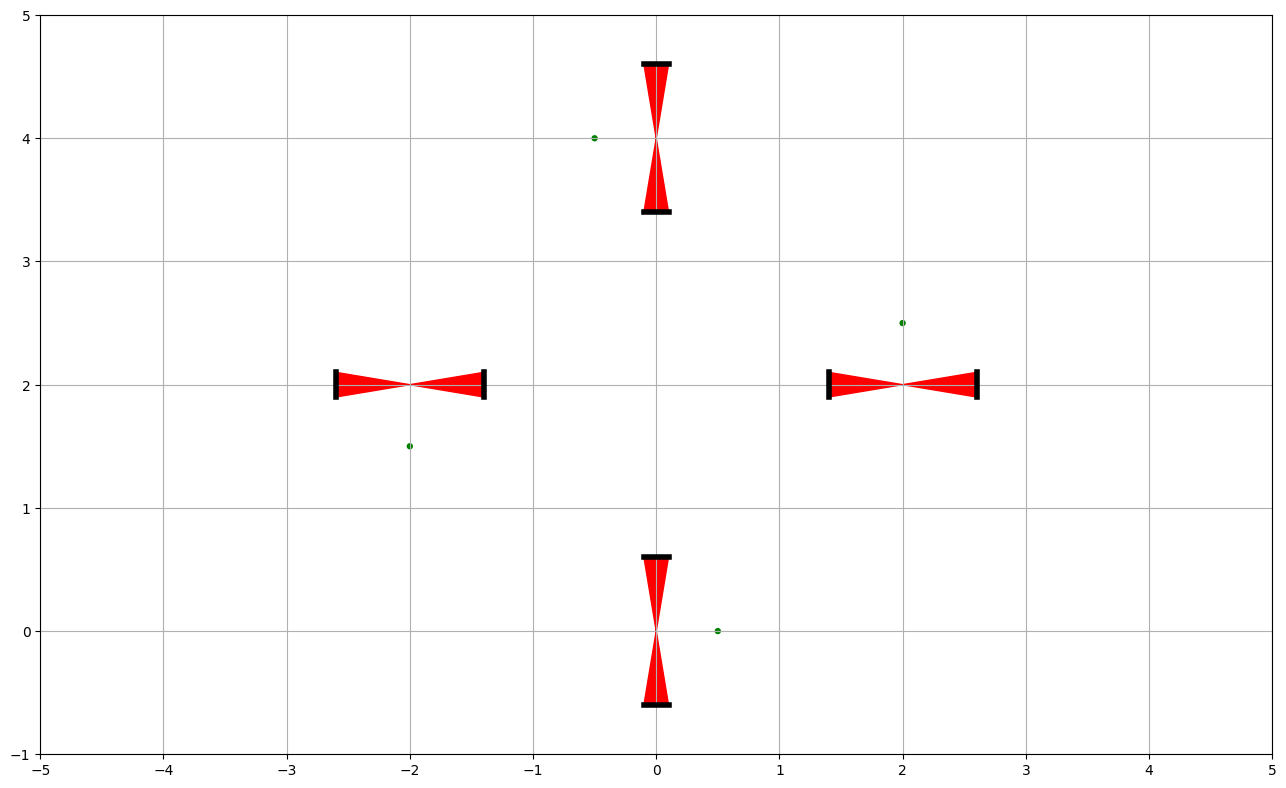

In [18]:
draw_arena(-5,5,-1,5)
draw_scooter(0,0,0)
draw_scooter(2,2,pi/2)
draw_scooter(0,4,pi)
draw_scooter(-2,2,3*pi/2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

To establish the differential equations relating the scooter's kinematics in terms of its coordinates $ (x, y)$, orientation $ \theta $, and the wheels' angular velocities $\omega_l $ and $\omega_r $, we can start by considering the geometry and motion constraints of the scooter.

### Geometry of the Scooter
1. **Wheel Diameter and Axis:** Let \(d\) be the diameter of each wheel, and $\(R = \frac{d}{2}\) be the radius. The wheels are fixed, parallel, and do not change orientation relative to the frame.
2. **Width of the Scooter:** Let \(w\) be the distance between the centers of the two wheels (i.e., the width of the scooter).

### No-slip Condition
The no-slip condition means that the linear velocity at the point of contact of each wheel with the ground is purely translational and matches the overall velocity of the scooter's frame. Thus, the tangential velocity of each wheel due to its rotation must be equal to the translational velocity of the scooter at those points.

### Kinematic Relations
Given the radius $ R $ of the wheels and the angular velocities $\omega_l $ and $ \omega_r $ of the left and right wheels, the translational velocities $ v_l $ and $ v_r $ of these wheels are given by:
$ v_l = R \omega_l $


$ v_r = R \omega_r $

### Average Velocity and Turning Rate
1. **Average Forward Velocity $(\dot{x}, \dot{y})$:**
   The average forward velocity of the scooter is the average of the velocities of the two wheels. Since the wheels are aligned parallel to the scooter's heading, the average forward velocity \(V\) in the direction $\theta\$ is:
    V = $\frac{v_l + v_r}{2} $

2. **Rotational Velocity $(\dot{\theta})$:**
   The difference in wheel velocities induces a rotational motion around the center point between the wheels. The angular velocity $\dot{\theta}$ of the scooter is given by the difference in wheel velocities divided by the width $ w $:
   $\dot{\theta} = \frac{v_r - v_l}{w}$

### Computing  $\dot{x} $ and $\dot{y}$
The velocity components in the global frame coordinates $ x$  and $ y $ can be determined from $V$ and $theta$ using:

$\dot{x} = V \cos(\theta)$

$\dot{y} = V \sin(\theta)$

Substituting $V $ from the average of $ v_l$ and $v_r$, we get:

$\dot{x} = \frac{R \omega_l + R \omega_r}{2} \cos(\theta) $

$\dot{y} = \frac{R \omega_l + R \omega_r}{2} \sin(\theta) $

$\dot{\theta} = \frac{R (\omega_r - \omega_l)}{w} $

### Final Differential Equations
$\dot{x} = R \frac{\omega_l + \omega_r}{2} \cos(\theta) $

$\dot{y} = R \frac{\omega_l + \omega_r}{2} \sin(\theta) $

$\dot{\theta} = \frac{R (\omega_r - \omega_l)}{w} $

These equations link the scooter's translational and rotational motion to the angular velocities of its wheels and form the basis for controlling its movement in the plane.

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

To demonstrate that the system of differential equations governing the kinematics of a self-balancing scooter is well-posed when $ \omega_l $ and $\omega_r $ are continuously differentiable functions of $(x, y, \theta) $, we need to examine the properties of existence, uniqueness, and continuous dependence on initial conditions for the solutions to these differential equations. These properties are generally assured by verifying that the system satisfies certain conditions often linked to the theory of ordinary differential equations.

### Functions $f$ and $g$
Let's define:

$f(x, y, \theta) = R \frac{\omega_l(x, y, \theta) + \omega_r(x, y, \theta)}{2} $

$g(x, y, \theta) = R \frac{\omega_r(x, y, \theta) - \omega_l(x, y, \theta)}{w}$

Thus, the system can be rewritten as:
$\dot{x} = f(x, y, \theta) \cos(\theta) $

$\dot{y} = f(x, y, \theta) \sin(\theta) $

$\dot{\theta} = g(x, y, \theta) $


### Analysis for Well-Posedness
1. **Continuously Differentiable**: Since $\omega_l$ and $\omega_r $ are given as continuously differentiable functions of $(x, y, \theta) $, it implies that $f $ and $g$ are also continuously differentiable with respect to $(x, y, \theta)$. This continuity in the first derivatives is critical.

2. **Existence and Uniqueness**: According to the Picard-Lindelöf theorem (a specific case of the Cauchy-Lipschitz theorem for ODEs), a system of ODEs $\dot{y} = F(y, t)$ where $F$ is Lipschitz continuous with respect to $y$ and continuous in $t$, guarantees local existence and uniqueness of solutions. In our case, $F(x, y, \theta) = (f(x, y, \theta) \cos(\theta), f(x, y, \theta) \sin(\theta), g(x, y, \theta)) $ fulfills these conditions because:
   - \( f \) and \( g \) being continuously differentiable ensure that \( F \) is Lipschitz continuous in a neighborhood of any point in the domain.

3. **Continuous Dependence on Initial Conditions**: The solutions also continuously depend on initial conditions, a consequence of the functions' continuous differentiability and the properties guaranteed by the Picard-Lindelöf theorem.

### Conclusion
Given that $f$ and $g$ derived from $\omega_l$ and $\omega_r$ are continuously differentiable, the system of differential equations is well-posed. This implies that for any initial condition $(x_0, y_0, \theta_0)$, there exists a unique solution $(x(t), y(t), \theta(t))$ that continuously depends on these initial conditions, at least locally around the initial point. This solution can be extended as long as the functions $f$ and $ g$ remain well-defined and their derivatives stay bounded.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

### Case of Constant \(\omega_l\) and \(\omega_r\)

When $\omega_l$ and $\omega_r$ are constants, the differential equations describing the scooter's motion are linear with respect to the trigonometric functions of $\theta\$, and the coefficients in these equations are constants:

$\dot{x} = R \frac{\omega_l + \omega_r}{2} \cos(\theta)$

$\dot{y} = R \frac{\omega_l + \omega_r}{2} \sin(\theta)$

$\dot{\theta} = \frac{R (\omega_r - \omega_l)}{w}$

In this scenario:
- The terms governing the dynamics are bounded since they involve constant coefficients and trigonometric functions.
- The equations do not contain any nonlinear terms or dependencies that could lead to unbounded behavior or singularities.
- Thus, the solutions are **global**, meaning they exist for all $ t \in (-\infty, \infty) $

### Case of Variable $\omega_l$ and $\omega_r$

When $\omega_l$ and $\omega_r$ are functions of $x, y$ and $\theta$ and are continuously differentiable:
- The system becomes nonlinear, potentially introducing complex dynamics.
- The behavior of $\omega_l(x, y, \theta)$ and $\omega_r(x, y, \theta)$ could lead to scenarios where the solution might blow up or become undefined within a finite time.
- **Global solutions are not guaranteed** without additional conditions that ensure boundedness and the absence of singular behaviors in $\omega_l$ and $\omega_r$

In summary, for constant $\omega_l$ and $\omega_r$, the solution is always global. For variable $\omega_l$ and $\omega_r$, additional analysis is required to assert the existence of global solutions.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [13]:
def omega(t, xytheta):
    omega_l = (1 - l/4) * pi / r
    omega_r = (1 + l/4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [15]:
import numpy as np

# Constants (Example values)
R = 0.5  # Radius of the wheels
l = 1.2  # Distance between the wheels

def omega(t, xytheta):
    r = 1.0  # Example radius for computation
    omega_l = (1 - 1/4) * np.pi / r
    omega_r = (1 + 1/4) * np.pi / r
    return np.array([omega_l, omega_r])

def fun(t, xytheta):
    x, y, theta = xytheta
    omega_values = omega(t, xytheta)
    omega_l = omega_values[0]
    omega_r = omega_values[1]

    # Compute the derivatives
    dot_x = R * (omega_l + omega_r) / 2 * np.cos(theta)
    dot_y = R * (omega_l + omega_r) / 2 * np.sin(theta)
    dot_theta = R * (omega_r - omega_l) / w

    return np.array([dot_x, dot_y, dot_theta])


### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)
   

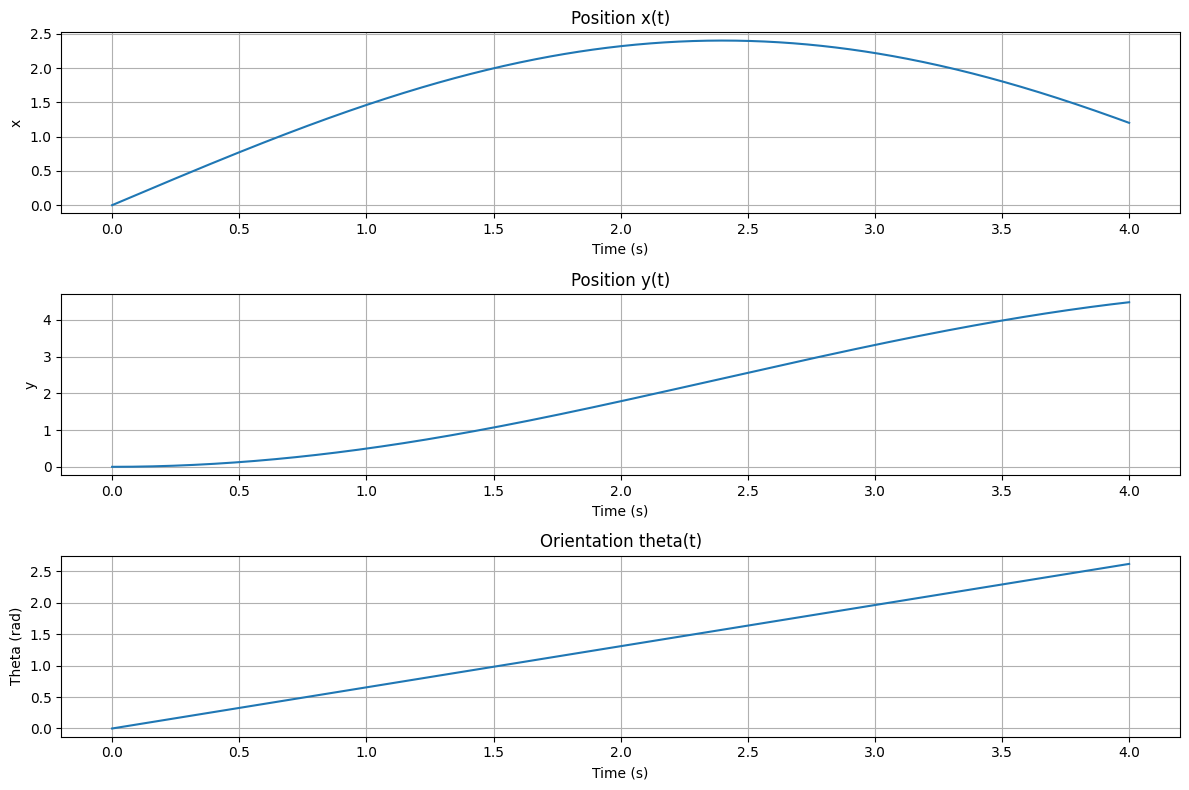

Time: 0.0s, Location: (x=0.00, y=0.00, theta=0.00 rad)
Time: 0.0s, Location: (x=0.01, y=0.00, theta=0.01 rad)
Time: 0.5s, Location: (x=0.78, y=0.13, theta=0.33 rad)
Time: 1.0s, Location: (x=1.46, y=0.50, theta=0.66 rad)
Time: 1.5s, Location: (x=2.00, y=1.08, theta=0.99 rad)
Time: 2.0s, Location: (x=2.32, y=1.79, theta=1.31 rad)
Time: 2.5s, Location: (x=2.40, y=2.56, theta=1.64 rad)
Time: 2.5s, Location: (x=2.39, y=2.57, theta=1.64 rad)
Time: 3.0s, Location: (x=2.21, y=3.32, theta=1.97 rad)
Time: 3.5s, Location: (x=1.80, y=3.98, theta=2.29 rad)
Time: 4.0s, Location: (x=1.20, y=4.48, theta=2.62 rad)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
R = 0.5  # Radius of the wheels
w = 1.2  # Distance between the wheels

# Initial conditions
xytheta0 = [0.0, 0.0, 0.0]
t_span = [0, 4]  # Time from 0 to 4 seconds
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Dense output for plotting

# Solve the system
sol = solve_ivp(fun, t_span, xytheta0, t_eval=t_eval, method='RK45')

# Plotting x(t), y(t), and theta(t)
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.title('Position x(t)')
plt.xlabel('Time (s)')
plt.ylabel('x')
plt.grid(True)

plt.subplot(312)
plt.plot(sol.t, sol.y[1], label='y(t)')
plt.title('Position y(t)')
plt.xlabel('Time (s)')
plt.ylabel('y')
plt.grid(True)

plt.subplot(313)
plt.plot(sol.t, sol.y[2], label='theta(t)')
plt.title('Orientation theta(t)')
plt.xlabel('Time (s)')
plt.ylabel('Theta (rad)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Display the robot location every 0.5 second
indices = np.where(np.isclose(sol.t % 0.5, 0, atol=1e-2))[0]
for idx in indices:
    print(f"Time: {sol.t[idx]:.1f}s, Location: (x={sol.y[0, idx]:.2f}, y={sol.y[1, idx]:.2f}, theta={sol.y[2, idx]:.2f} rad)")


🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

In [ ]:
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

In [ ]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?

**TODO**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [ ]:
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.

In [ ]:
pass